# 무엇이 음원 차트 순위를 결정하는가
### 왜 어떤 음원은 유명해지고 어떤 건 그렇지 못하는가
1. 연구 목표: 차트 하위권에 머무는 음원과 상위권으로 역주행하는 음원의 차이를 만드는 요소 확인
2. 연구 대상: 2019년, 차트에 5주 이상 머물렀던 국내 음원

## 개요
1. 데이터 수집 및 전처리
2. k-means clustering을 통해 상위권/하위권/역주행 음원 분류
3. sentiment analysis를 이용해 노래 가사의 긍정/부정 판단
4. 히트맵을 그려 수집한 feature간 관계 확인
5. Random Forest와 Decision Tree

## 1. 데이터 수집 및 전처리

In [1]:
import pickle as p
keys = p.load(open('./data/data_top100.p', 'rb'))

In [2]:
#자료 형태 확인
keys

{'벤 180도': {'first appeared': Timedelta('29 days 00:00:00'),
  'fandom': 81783,
  'highest': 1,
  'chartin rank': 1,
  'duration': 38,
  'nation': '대한민국',
  '2018': True,
  'is title': True,
  'track cnt': 5,
  'genre': ['발라드']},
 '엠씨더맥스 넘쳐흘러': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom': 112944,
  'highest': 1,
  'chartin rank': 2,
  'duration': 42,
  'nation': '대한민국',
  '2018': False,
  'is title': True,
  'track cnt': 14,
  'genre': ['발라드']},
 '제니 SOLO': {'first appeared': Timedelta('54 days 00:00:00'),
  'fandom': 29128,
  'highest': 3,
  'chartin rank': 3,
  'duration': 27,
  'nation': '대한민국',
  '2018': True,
  'is title': True,
  'track cnt': 1,
  'genre': ['랩/힙합']},
 '하은 신용재': {'first appeared': Timedelta('60 days 00:00:00'),
  'fandom': 8793,
  'highest': 4,
  'chartin rank': 4,
  'duration': 34,
  'nation': '대한민국',
  '2018': True,
  'is title': True,
  'track cnt': 4,
  'genre': ['발라드']},
 '청하 벌써 12시': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom'

* 장르를 가장 선두에 있는 하나만 남겨두고, 그 하나를 숫자로 바꿔주자.

{'발라드': 0, '랩/힙합': 1, '댄스': 2, '알앤비/어반': 3, '드라마음악': 4, '락': 5, '팝': 6, '인디뮤직': 7, '영화음악': 8, '포크': 9, '일렉트로니카': 10, '트로트': 11, '게임': 12, '팝락': 13}


<BarContainer object of 14 artists>

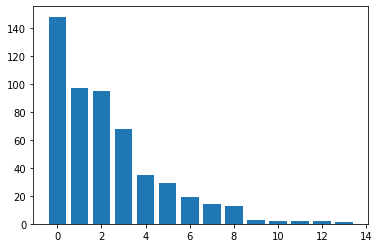

In [3]:
#장르 리스트
genres = []
for key in keys:
    if "genre" in keys[key]:
        if keys[key]["genre"][0] not in genres:
            genres.append(keys[key]["genre"][0])
            
#각 장르의 등장 횟수 세기
genre_cnt = {}
for key in keys:
    if "genre" in keys[key]:
        genre = keys[key]["genre"][0]
        if genre in genre_cnt:
            genre_cnt[genre] += 1
        else:
            genre_cnt[genre] = 1
        
#자주 등장한 순서대로 리스트 정렬하기
genre_sorted = []
while(len(genre) > 0):
    
    cnt_max = 0
    genre_max = ""
 
    for genre in genres:
        if genre_cnt[genre] > cnt_max:
            cnt_max = genre_cnt[genre]
            genre_max = genre
    
    if cnt_max != 0:
        genre_sorted.append(genre_max)
        genres.remove(genre_max)
    else:
        break

#자주 등장한 순서대로 숫자 부여하기
num = {}
e = enumerate(genre_sorted)
for ee in e:
    num[ee[1]] = ee[0]    

print(num)

#시각화
X = range(len(genre_sorted))
Y = []
for genre in genre_sorted:
    Y.append(genre_cnt[genre])

plt.bar(X, Y)

In [4]:
#데이터 업데이트
for key in keys:
    if "genre" in keys[key]:
        genre_o = keys[key]["genre"][0]
        keys[key]["genre"] = num[genre_o]
        
keys

{'벤 180도': {'first appeared': Timedelta('29 days 00:00:00'),
  'fandom': 81783,
  'highest': 1,
  'chartin rank': 1,
  'duration': 38,
  'nation': '대한민국',
  '2018': True,
  'is title': True,
  'track cnt': 5,
  'genre': 0},
 '엠씨더맥스 넘쳐흘러': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom': 112944,
  'highest': 1,
  'chartin rank': 2,
  'duration': 42,
  'nation': '대한민국',
  '2018': False,
  'is title': True,
  'track cnt': 14,
  'genre': 0},
 '제니 SOLO': {'first appeared': Timedelta('54 days 00:00:00'),
  'fandom': 29128,
  'highest': 3,
  'chartin rank': 3,
  'duration': 27,
  'nation': '대한민국',
  '2018': True,
  'is title': True,
  'track cnt': 1,
  'genre': 1},
 '하은 신용재': {'first appeared': Timedelta('60 days 00:00:00'),
  'fandom': 8793,
  'highest': 4,
  'chartin rank': 4,
  'duration': 34,
  'nation': '대한민국',
  '2018': True,
  'is title': True,
  'track cnt': 4,
  'genre': 0},
 '청하 벌써 12시': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom': 91786,
  'highest': 2,


* 조건에 맞는 음원(2018년에는 차트에 없었음, 국내 음원임, 차트 안에 5주 이상 머무름) 외에는 제거한다

In [5]:
no = [] #조건에 맞지 않는 음원
for k in keys:
    if(keys[k]["nation"] != "대한민국"  or keys[k]["duration"] < 5 or keys[k]["2018"] == True):
        no.append(k)
        
new_key = [] #조건에 맞는 음원
for k in keys:
    if k not in no:
        new_key.append(k)
        
print("총 음원 개수: %d" %(len(new_key)))

총 음원 개수: 208


## 2. k-means clustering

* 산포도 확인

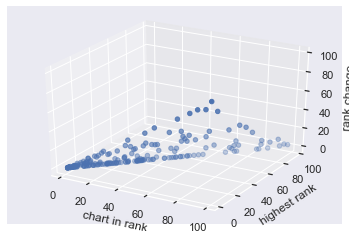

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%matplotlib inline

#x축에는 차트 진입 순위
x = []
for k in new_key:
    x.append(keys[k]["chartin rank"])
    
X = np.array(x).reshape(len(x), 1)

#y축에는 차트 내 최고 순위
y = []
for k in new_key:
    y.append(keys[k]["highest"])

Y = np.array(y).reshape(len(x), 1)

#z축에는 차트 인 이후 상승한 등수
z = []
for k in new_key:
    z.append(keys[k]["chartin rank"] - keys[k]["highest"])

Z = np.array(z).reshape(len(z), 1)

fit = np.concatenate([X, Y, Z], axis = 1)

#plot
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.scatter(X, Y, Z)
ax.set_xlabel('chart in rank')
ax.set_ylabel('highest rank')
ax.set_zlabel('rank change')
plt.show() 

* k-means clustering

Text(0.5, 0, 'rank change')

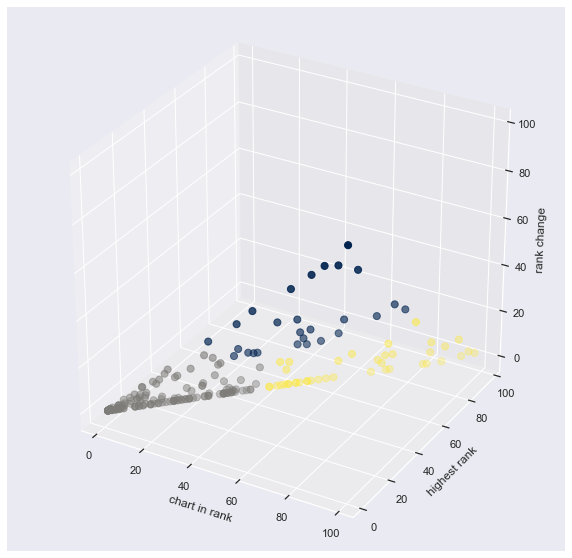

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3) #3개 클러스터(상위권, 하위권, 역주행)
kmeans.fit(fit)
y_kmeans = kmeans.predict(fit) 

fig = plt.figure(figsize = (10, 10)) 
ax = plt.axes(projection ="3d")
ax.scatter3D(X, Y, Z, c = y_kmeans, s = 50, cmap = 'cividis');
ax.set_xlabel('chart in rank')
ax.set_ylabel('highest rank')
ax.set_zlabel('rank change')

* 아래와 같이 확인해보면, 상위권 음원은 0, 하위권은 1, 역주행 음원은 2로 라벨링된 걸 알 수 있다.

In [8]:
for i in range(len(new_key)):
    if y_kmeans[i] == 2:
        print(new_key[i], keys[new_key[i]]["chartin rank"], keys[new_key[i]]["highest"])

이수 My Way 98 93
청하 Roller Coaster 94 82
방탄소년단 Answer _ Love Myself 99 83
수퍼비 Heu !  78 66
임한별 사랑 이딴 거 84 84
이석훈 사랑하지 말아요  70 70
세븐틴 어쩌나 99 96
첸 Make it count 75 75
잔나비 나는 볼 수 없던 이야기 89 80
헤이즈 오롯이 53 34
하성운 BIRD 66 53
장덕철 시작됐나, 봄 47 47
버스커 버스커 벚꽃 엔딩 52 40
잔나비 She  55 37
볼빨간사춘기 Seattle Alone 43 43
길구봉구 있어줄래 56 56
임한별 오월의 어느 봄날  80 68
공기남 Gloomy Star  89 89
방탄소년단 Dream Glow  92 75
창모 비워  43 43
SIXC 움직여  54 54
크레파스 이뻐이뻐  53 53
하은 비오는 날 뭐해 60 60
비와이 가라사대 94 59
오마이걸 BUNGEE  50 50
레드벨벳 어떤 별보다 50 50
태용 러브 델루나 46 46
X1 웃을 때 제일 예뻐 75 69
에이치코드 꿈속에 너  82 61
Woodie Gochild 바다  48 48
악동뮤지션 고래 53 53
악동뮤지션 작별 인사 58 58
첸 널 안지 않을 수 있어야지 74 74
이우 이별행동 48 48
기리보이 호랑이소굴  45 45
현아 FLOWER SHOWER 71 54
AOA 날 보러 와요  51 51
EXO Trouble 85 85
EXO 춤  95 93
V.O.S 잘 살고 있다 75 66


* 분류한 결과를 dictionary 형태로 저장한다.

In [9]:
high = []
low = []
rise = []
for i in range(len(new_key)):
    if y_kmeans[i] == 0:
        low.append(new_key[i])
    elif y_kmeans[i] == 1:
        high.append(new_key[i])
    else:
        rise.append(new_key[i])
        
category = {"high": high, "low": low, "rise": rise}

* 추려낸 208개에 대해서 트위터 크롤링

In [10]:
twitter = p.load(open('./data/twitter.p', 'rb'))
twitter

{'엠씨더맥스 넘쳐흘러': {'tweet': 232},
 '청하 벌써 12시': {'tweet': 2292},
 '숀 습관 ': {'tweet': 294},
 '엠씨더맥스 사계 ': {'tweet': 175},
 '이수 My Way': {'tweet': 10},
 '청하 Roller Coaster': {'tweet': 93},
 '방탄소년단 Answer _ Love Myself': {'tweet': 270},
 '하진 We all lie': {'tweet': 67},
 '케이시 그때가 좋았어': {'tweet': 8},
 'god 길 ': {'tweet': 149},
 'Jvcki Wai 띵 ': {'tweet': 196},
 '여자친구 해야 ': {'tweet': 3503},
 '폴킴 초록빛': {'tweet': 239},
 '이소라 신청곡 ': {'tweet': 901},
 '세븐틴 Home': {'tweet': 18898},
 '황치열 이별을 걷다 ': {'tweet': 198},
 '수퍼비 Heu ! ': {'tweet': 11},
 '임한별 사랑 이딴 거': {'tweet': 10},
 '이석훈 사랑하지 말아요 ': {'tweet': 13},
 '우디 이 노래가 클럽에서 나온다면': {'tweet': 54},
 '세븐틴 어쩌나': {'tweet': 218},
 '하성운 잊지마요 ': {'tweet': 3240},
 '로꼬 오랜만이야 ': {'tweet': 286},
 '첸 Make it count': {'tweet': 553},
 '잔나비 나는 볼 수 없던 이야기': {'tweet': 11},
 '화사 멍청이': {'tweet': 1752},
 'ITZY 달라달라': {'tweet': 1316},
 '헤이즈 오롯이': {'tweet': 190},
 '엔플라잉 옥탑방': {'tweet': 1087},
 '닐로 미운 날 ': {'tweet': 175},
 '강민경 사랑해서 그래': {'tweet': 194},
 '하성운 BIRD': {'tweet': 54

## 3. Sentiment Analysis: 가사 감성분석

* KoNLPy와 LSTM을 이용한 텍스트 감정분석
* 참고문헌: 딥 러닝을 이용한 자연어 처리 입문 https://wikidocs.net/book/2155

In [11]:
import pandas as pd
import re

lyric = p.load(open('./data/lyric_dic.p', 'rb'))
train = pd.read_table("./data/ratings_train.txt")
test = pd.read_table("./data/ratings_test.txt")

#중복된 데이터 제거
train.drop_duplicates(subset=['document'], inplace=True)
test.drop_duplicates(subset=['document'], inplace=True)

#정규표현식을 이용해 한글 텍스트만 남기고 제거
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'].replace('', np.nan, inplace=True)
test['document'].replace('', np.nan, inplace=True)

#빈 데이터 제거
train = train.dropna(how = 'any')
test = test.dropna(how = 'any')

train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


* 불용어는 Ranks NL 제공 https://www.ranks.nl/stopwords/korean

In [12]:
#stopword; 불용어
stopwords = []
pd_stopwords = pd.read_table("./data/stopwords.txt", header = 0)
for i in range(len(pd_stopwords['불용어'])):
    stopwords.append(pd_stopwords['불용어'][i])

* 형태소 분석은 Okt(과거엔 'twitter'라는 명칭으로 사용됨) 사용. 고유명사와 감탄사 처리에 적합하다고 판단.

In [13]:
from konlpy.tag import Okt
okt = Okt()

#토큰화
def tokenization(text_df): 
    token = []
    for text in text_df:
        temp = []
        okt1 = okt.morphs(str(text))
        for word in okt1:
            if word not in stopwords:
                temp.append(word)
        token.append(temp)
    
    return token

train_token = tokenization(train['document'])
test_token = tokenization(test['document'])

KeyboardInterrupt: 

* 정수 인코딩

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(train_token)
tokenizer.fit_on_texts(test_token)

#빈도수가 10 미만인 단어 삭제
token_count = tokenizer.word_index
total_cnt = len(token_count)
rare_cnt = 0

for key in token_count:
    if(token_count[key] < 10):
        rare_cnt += 1

vocab_size = total_cnt - rare_cnt + 2

#빈도수가 10 이상인 단어만 정수 인코딩
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(train_token)
train_token = tokenizer.texts_to_sequences(train_token)
test_token = tokenizer.texts_to_sequences(test_token)

#label
train_label = np.array(train['label'])
test_label = np.array(test['label'])

In [64]:
#빈 샘플 제거
empty = []
for t in enumerate(train_token):
    if len(t[1]) < 1:
        empty.append(t[0])
        
train_token = np.delete(train_token, empty, axis=0)
train_label = np.delete(train_label, empty, axis=0)

empty = []
for t in enumerate(test_token):
    if len(t[1]) < 1:
        empty.append(t[0])
        
test_token = np.delete(test_token, empty, axis=0)
test_label = np.delete(test_label, empty, axis=0)

c:\users\sees hyeonjin kim\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


* 패딩

In [65]:
from tensorflow.keras.preprocessing import sequence
train_token = sequence.pad_sequences(train_token, maxlen = 35)
test_token = sequence.pad_sequences(test_token, maxlen = 35)

* LSTM
* activation fuction을 sigmoid로 쓰나 relu로 쓰나 정확도에 유의미한 차이는 없었다.
* layer의 개수가 늘어나면 실행 시간만 길어지고 정확도의 향상에는 크게 기여하지 않았다.
* epoch 10개 안팎에서 early stopping이 일어나므로 epoch는 최대 15개면 충분하다.
* optimizer는 RNN에 자주 사용되는 rmsprop을 이용한다.

In [66]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='relu'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./weight/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_token, train_label, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1937/1937 [==============================] - ETA: 0s - loss: 0.3994 - acc: 0.8164
Epoch 00001: val_acc improved from -inf to 0.84280, saving model to best_model.h5
1937/1937 [==============================] - 422s 218ms/step - loss: 0.3994 - acc: 0.8164 - val_loss: 0.3525 - val_acc: 0.8428
Epoch 2/15
1937/1937 [==============================] - ETA: 0s - loss: 0.3167 - acc: 0.8645
Epoch 00002: val_acc improved from 0.84280 to 0.85440, saving model to best_model.h5
1937/1937 [==============================] - 396s 205ms/step - loss: 0.3167 - acc: 0.8645 - val_loss: 0.3346 - val_acc: 0.8544
Epoch 3/15
1937/1937 [==============================] - ETA: 0s - loss: 0.2695 - acc: 0.8914
Epoch 00003: val_acc improved from 0.85440 to 0.85592, saving model to best_model.h5
1937/1937 [==============================] - 406s 210ms/step - loss: 0.2695 - acc: 0.8914 - val_loss: 0.3317 - val_acc: 0.8559
Epoch 4/15
1937/1937 [==============================] - ETA: 0s - loss: 0.2305 - acc: 0.

In [67]:
loaded_model = load_model('./weight/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_token, test_label)[1]))

1525/1525 [==============================] - 62s 40ms/step - loss: 0.3372 - acc: 0.8531

 테스트 정확도: 0.8531


* 학습 끝 예측 시작

In [68]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    #가사가 충분히 포함될 수 있도록 maxlen을 길게 잡았다
    pad_new = sequence.pad_sequences(encoded, maxlen = 500)
    score = float(model.predict(pad_new))
     
    return score

In [71]:
sentiment_dic = {}
for key in lyric:
    sentiment = sentiment_predict(lyric[key])
    if key == '아이들 Senorita':
        sentiment_dic['(여자)아이들 Senorita'] = sentiment
    elif key == '아이들 Uh-Oh':
        sentiment_dic['(여자)아이들 Uh-Oh'] = sentiment
    elif key == '아이들 LION':
        sentiment_dic['(여자)아이들 LION'] = sentiment
    else:
        sentiment_dic[key] = sentiment
    
sentiment_dic

{'엠씨더맥스 넘쳐흘러': 0.2644338607788086,
 '청하 벌써 12시': 0.9956480860710144,
 '숀 습관 ': 0.0065858145244419575,
 '엠씨더맥스 사계 ': 0.9981805086135864,
 '이수 My Way': 0.38482901453971863,
 '청하 Roller Coaster': 0.014653819613158703,
 '방탄소년단 Answer _ Love Myself': 0.0020995941013097763,
 '하진 We all lie': 0.0025002192705869675,
 '케이시 그때가 좋았어': 0.22348828613758087,
 'god 길 ': 0.14598862826824188,
 'Jvcki Wai 띵 ': 0.9866334199905396,
 '여자친구 해야 ': 0.9952800273895264,
 '폴킴 초록빛': 0.004846550058573484,
 '이소라 신청곡 ': 0.9826921224594116,
 '세븐틴 Home': 0.002499905414879322,
 '황치열 이별을 걷다 ': 0.9984537363052368,
 '수퍼비 Heu ! ': 0.002147318096831441,
 '임한별 사랑 이딴 거': 0.0016584203112870455,
 '이석훈 사랑하지 말아요 ': 0.23805636167526245,
 '우디 이 노래가 클럽에서 나온다면': 0.0023481727112084627,
 '세븐틴 어쩌나': 0.9993903636932373,
 '하성운 잊지마요 ': 0.0013668830506503582,
 '로꼬 오랜만이야 ': 0.005328524392098188,
 '첸 Make it count': 0.9971786737442017,
 '잔나비 나는 볼 수 없던 이야기': 0.001333671621978283,
 '화사 멍청이': 0.0025130801368504763,
 'ITZY 달라달라': 0.00131682178471

* 이제 트위터 언급량과 가사 감성분석 결과 포함 모든 feature, 그리고 high/low/rise 정보가 담긴 dictionary를 만들자.
* high는 0, low는 1, rise는 2로 tagging하겠다.

In [142]:
#예측에 사용할 모든 feature가 포함된 dictionary 생성
data_final = {}
for key in twitter:
    if key == '(여자)아이들 Senorita':
        data_final[key] = keys['아이들 Senorita']
    elif key == '(여자)아이들 Uh-Oh':
        data_final[key] = keys['아이들 Uh-Oh']
    elif key == '(여자)아이들 LION':
        data_final[key] = keys['아이들 LION']
    else:
        data_final[key] = keys[key]
    
    data_final[key]["twitter"] = twitter[key]["tweet"]
    data_final[key]["sentiment"] = sentiment_dic[key]
    
    #high/low/rise tagging
    if key in category["high"]:
        data_final[key]["tag"] = 0
    elif key in category["low"]:
        data_final[key]["tag"] = 1
    else:
        data_final[key]["tag"] = 2
    
data_final

{'엠씨더맥스 넘쳐흘러': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom': 112944,
  'highest': 1,
  'chartin rank': 2,
  'duration': 42,
  'nation': '대한민국',
  '2018': False,
  'is title': True,
  'track cnt': 14,
  'genre': 0,
  'twitter': 232,
  'sentiment': 0.2644338607788086,
  'tag': 0},
 '청하 벌써 12시': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom': 91786,
  'highest': 2,
  'chartin rank': 5,
  'duration': 42,
  'nation': '대한민국',
  '2018': False,
  'is title': True,
  'track cnt': 1,
  'genre': 2,
  'twitter': 2292,
  'sentiment': 0.9956480860710144,
  'tag': 0},
 '숀 습관 ': {'first appeared': Timedelta('4 days 00:00:00'),
  'fandom': 18663,
  'highest': 16,
  'chartin rank': 16,
  'duration': 12,
  'nation': '대한민국',
  '2018': False,
  'is title': True,
  'track cnt': 3,
  'genre': 10,
  'twitter': 294,
  'sentiment': 0.0065858145244419575,
  'tag': 0},
 '엠씨더맥스 사계 ': {'first appeared': Timedelta('3 days 00:00:00'),
  'fandom': 112944,
  'highest': 20,
  'chartin rank': 

## 4. feature 히트맵

In [143]:
dfs = []

for key in data_final:
    df = pd.DataFrame(data_final[key], index = [key])
    #timedelta type의 데이터를 int type으로 바꿔준다
    df.loc[key, 'first appeared'] = (df.loc[key, 'first appeared'].days)/7 + 1
    dfs.append(df)
    
temp = dfs[0]

for df in dfs[1:]:
    temp = pd.concat([temp, df])

temp = temp.drop(columns = ["2018", "nation", "duration", "tag"])
temp['first appeared'] = temp['first appeared'].astype('int')
temp.corr()

,first appeared,fandom,highest,chartin rank,is title,track cnt,genre,twitter,sentiment
first appeared,1.000000,-0.061249,0.039628,0.164571,-0.122967,0.166150,-0.015137,-0.055566,0.006919
fandom,-0.061249,1.000000,0.001786,-0.067715,-0.448258,0.331731,0.355447,0.192026,0.086370
highest,0.039628,0.001786,1.000000,0.761838,-0.139099,0.065526,-0.004464,-0.128807,0.005469
chartin rank,0.164571,-0.067715,0.761838,1.000000,-0.088891,0.055573,-0.048282,-0.174114,-0.058138
is title,-0.122967,-0.448258,-0.139099,-0.088891,1.000000,-0.360927,-0.222888,0.081139,-0.114980
track cnt,0.166150,0.331731,0.065526,0.055573,-0.360927,1.000000,0.193570,0.142026,0.056086
genre,-0.015137,0.355447,-0.004464,-0.048282,-0.222888,0.193570,1.000000,-0.016193,0.009464
twitter,-0.055566,0.192026,-0.128807,-0.174114,0.081139,0.142026,-0.016193,1.000000,-0.144650
sentiment,0.006919,0.086370,0.005469,-0.058138,-0.114980,0.056086,0.009464,-0.144650,1.000000


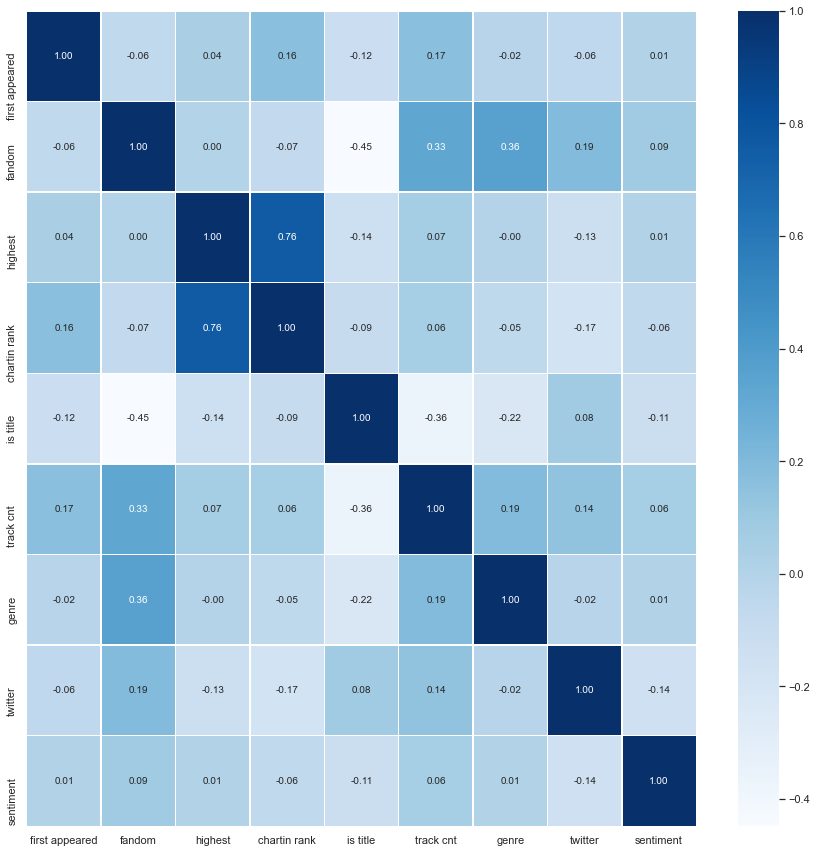

In [144]:
plt.figure(figsize=(15,15))
sns.heatmap(data = temp.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

## 5. 의사결정 나무

* 분류에 사용할 feature와 tag로 구성된 데이터프레임 생성

In [161]:
dfs = []

for key in data_final:
    df = pd.DataFrame(data_final[key], index = [key])
    #timedelta type의 데이터를 int type으로 바꿔준다
    df.loc[key, 'first appeared'] = (df.loc[key, 'first appeared'].days)/7 + 1
    dfs.append(df)
    
final_df = dfs[0]

for df in dfs[1:]:
    final_df = pd.concat([final_df, df])

final_df = final_df.drop(columns = ["2018", "nation", "duration", "highest"])
final_df['first appeared'] = final_df['first appeared'].astype('int')
final_df

,first appeared,fandom,chartin rank,is title,track cnt,genre,twitter,sentiment,tag
엠씨더맥스 넘쳐흘러,1,112944,2,True,14,0,232,0.264434,0
청하 벌써 12시,1,91786,5,True,1,2,2292,0.995648,0
숀 습관,1,18663,16,True,3,10,294,0.006586,0
엠씨더맥스 사계,1,112944,29,False,14,0,175,0.998181,0
이수 My Way,61,24909,98,True,2,4,10,0.384829,1
...,...,...,...,...,...,...,...,...,...
박진영 FEVER,1,13953,30,False,4,2,94,0.001756,0
V.O.S 잘 살고 있다,1,13226,75,True,2,0,1,0.002610,1
(여자)아이들 Senorita,1,56240,30,True,5,2,963,0.549781,2
(여자)아이들 Uh-Oh,1,56240,62,True,1,1,699,0.002327,2


* classification

In [162]:
X_train = np.array(final_df.loc[:, 'first appeared':'sentiment'].iloc[:140, :])
y_train = np.array(final_df.loc[:, 'tag'].iloc[:140])

X_test = np.array(final_df.loc[:, 'first appeared':'sentiment'].iloc[140:, :])
y_test = np.array(final_df.loc[:, 'tag'].iloc[140:])

In [163]:
def calculate(predict, answer):
    right_cnt = 0
    wrong_cnt = 0
    for i in range(size(predict)):
        if predict[i] == answer[i]:
            right_cnt += 1
        else:
            wrong_cnt += 1   
    print("정확도는 %f" %(right_cnt/(right_cnt + wrong_cnt) * 100) + "% 입니다")

In [164]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
Z1 = clf.predict(X_test)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
Z2 = model.predict(X_test)

In [165]:
calculate(Z1, y_test) #Decision Tree
calculate(Z2, y_test) #Random Forest

정확도는 76.470588% 입니다
정확도는 79.411765% 입니다


* 'sentiment' feature를 제외시키고 classification을 하면 정확도가 올라간다.

In [166]:
X_train = np.array(final_df.loc[:, 'first appeared':'twitter'].iloc[:140, :])
y_train = np.array(final_df.loc[:, 'tag'].iloc[:140])

X_test = np.array(final_df.loc[:, 'first appeared':'twitter'].iloc[140:, :])
y_test = np.array(final_df.loc[:, 'tag'].iloc[140:])

In [167]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
Z1 = clf.predict(X_test)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
Z2 = model.predict(X_test)

calculate(Z1, y_test) #Decision Tree
calculate(Z2, y_test) #Random Forest

정확도는 79.411765% 입니다
정확도는 88.235294% 입니다


* sentiment를 제외한 결과를 시각화하자.

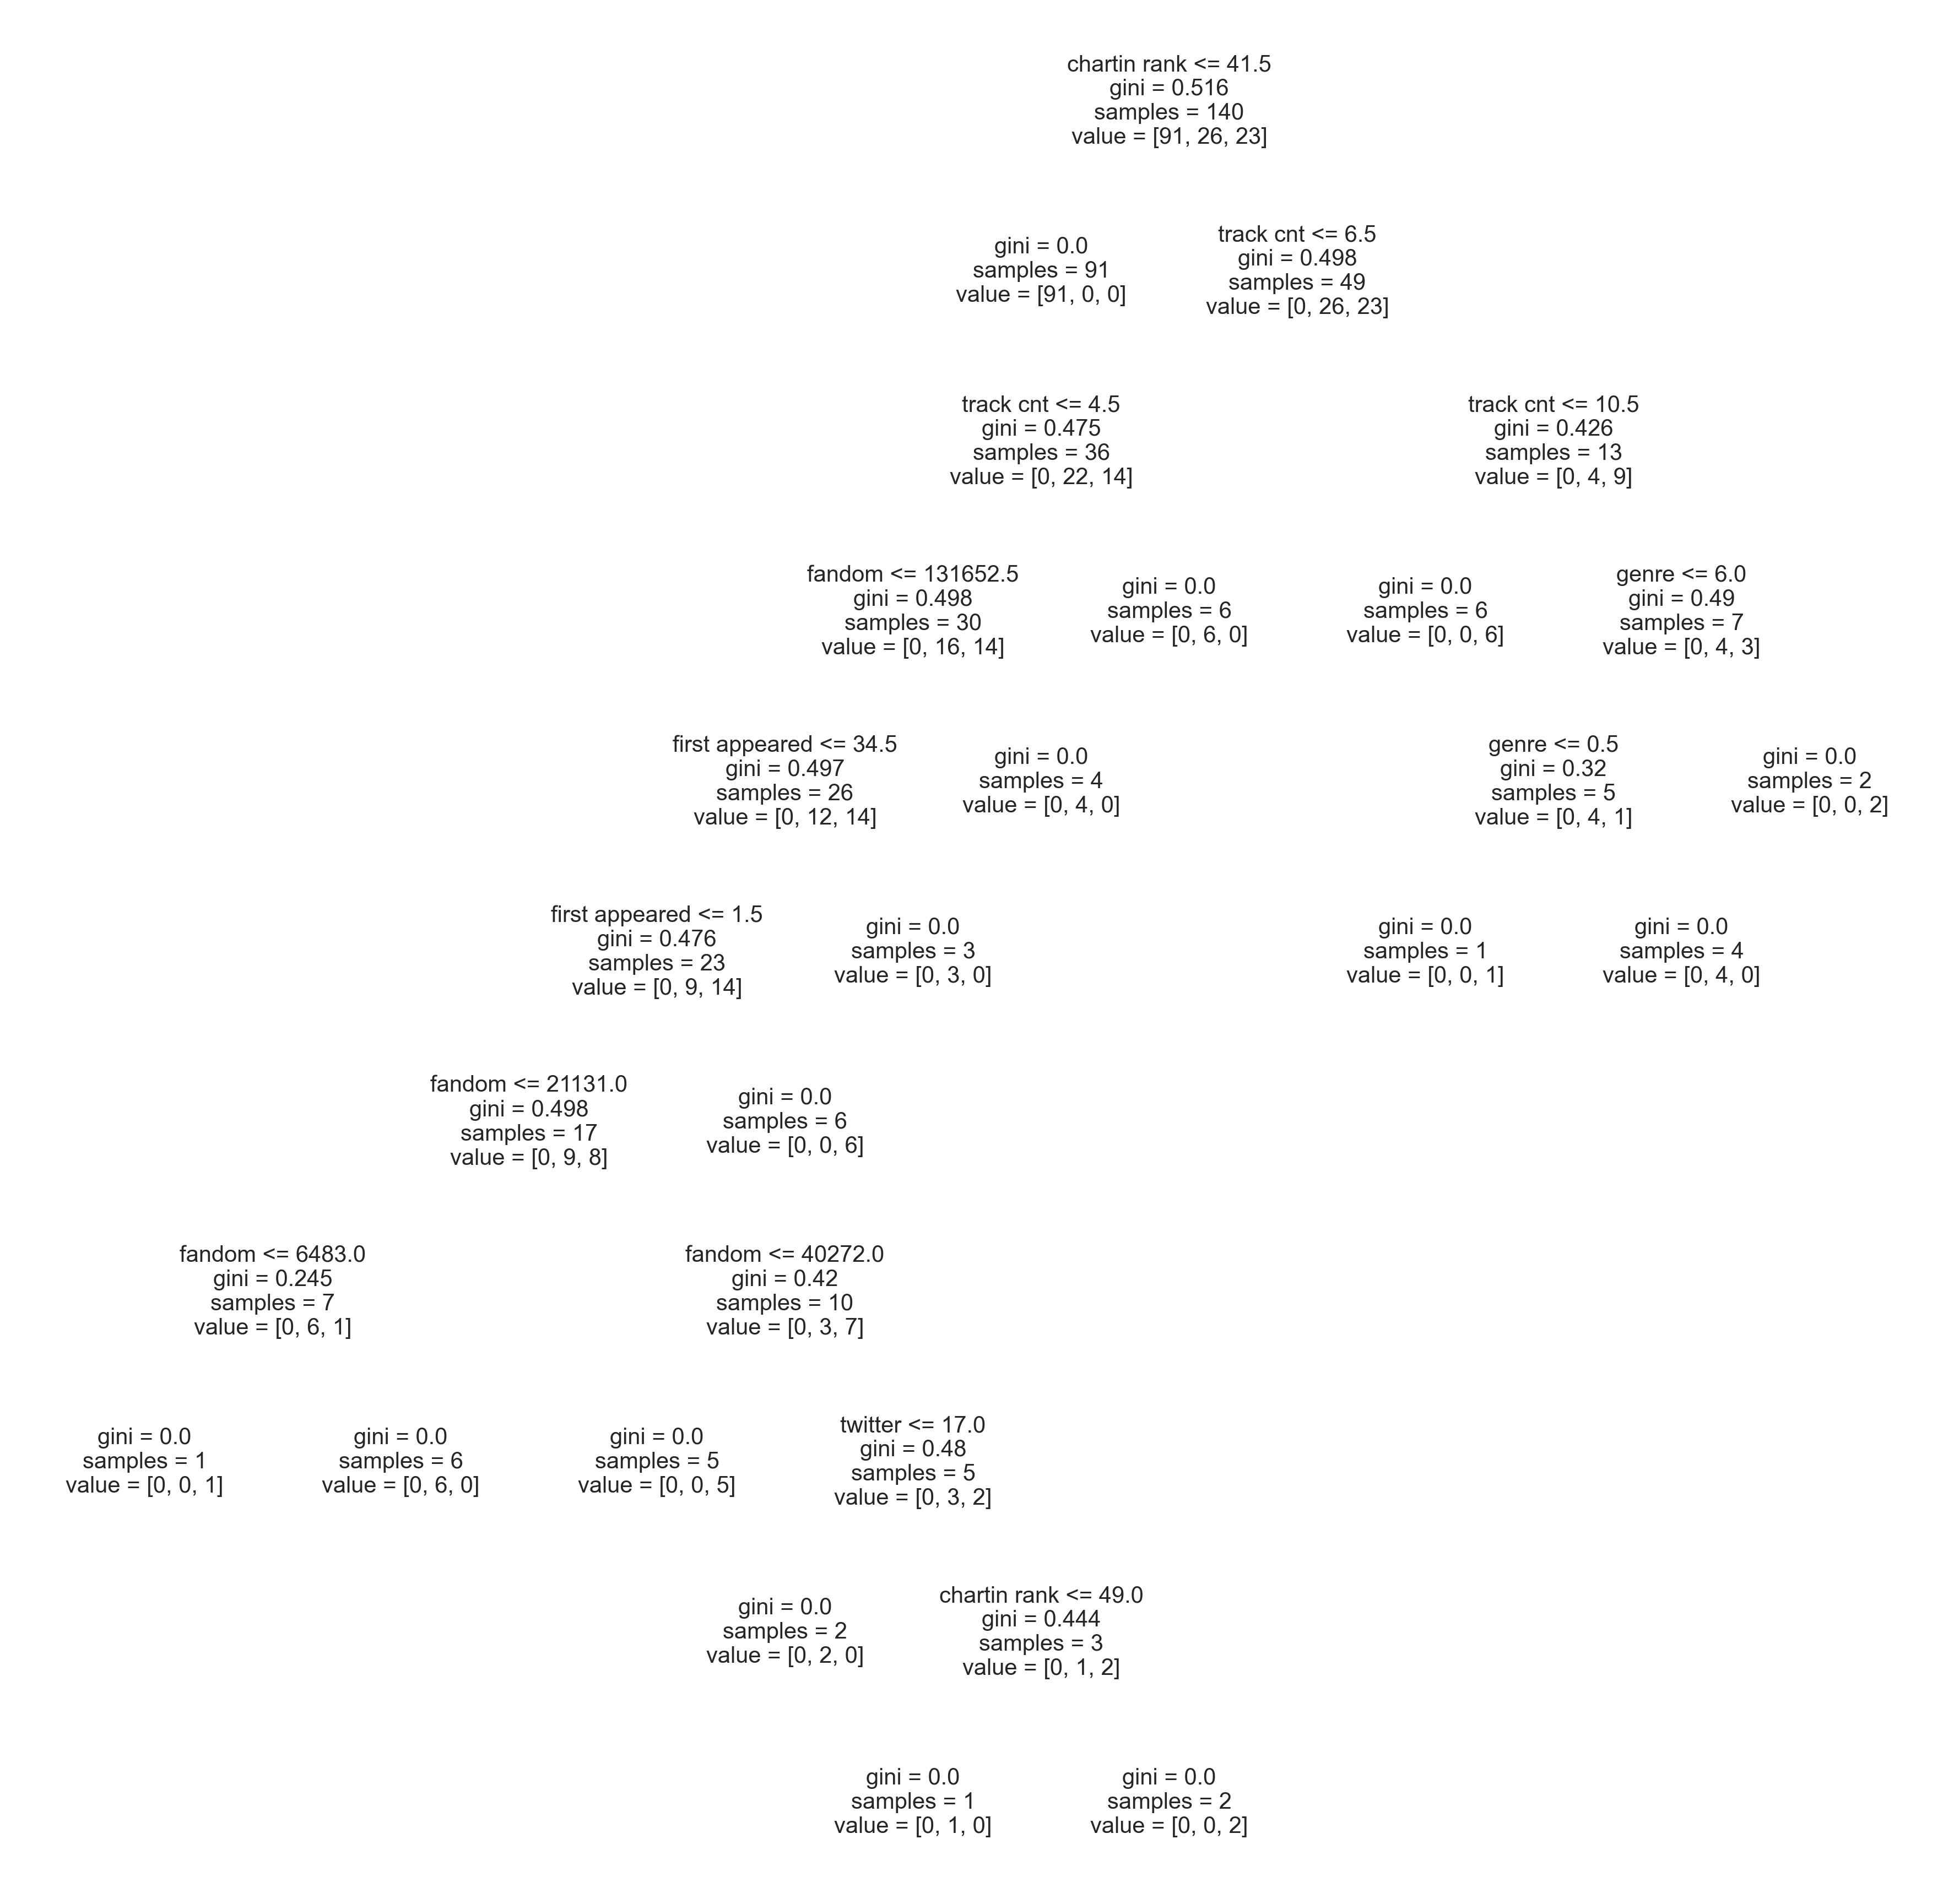

In [168]:
from sklearn import tree

#Decision Tree 시각화
fig, ax = plt.subplots(figsize=(15, 15), dpi = 300)
tree.plot_tree(clf, fontsize = 10, feature_names = list(final_df.columns)[:-1], rounded = True)
plt.show()

<BarContainer object of 7 artists>

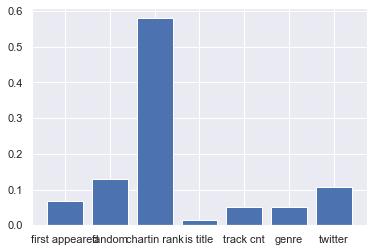

In [169]:
#Random Forest에서 각 요소의 중요도 시각화하기
X = []
Y = []
importance = model.feature_importances_

for i in range(7):
    X.append(final_df.columns[:9][i])
    Y.append(importance[i])
    
plt.bar(X, Y)

* 의사결정나무가 low와 rise를 구분하는 정확도 확인

In [170]:
dfs = []

for key in data_final:
    df = pd.DataFrame(data_final[key], index = [key])
    #timedelta type의 데이터를 int type으로 바꿔준다
    df.loc[key, 'first appeared'] = (df.loc[key, 'first appeared'].days)/7 + 1
    if df.loc[key, 'tag'] != 0:
        dfs.append(df)
    
final_df = dfs[0]

for df in dfs[1:]:
    final_df = pd.concat([final_df, df])

final_df = final_df.drop(columns = ["2018", "nation", "duration", "highest"])
final_df['first appeared'] = final_df['first appeared'].astype('int')
final_df

,first appeared,fandom,chartin rank,is title,track cnt,genre,twitter,sentiment,tag
이수 My Way,61,24909,98,True,2,4,10,0.384829,1
청하 Roller Coaster,51,91786,94,True,5,2,93,0.014654,1
방탄소년단 Answer _ Love Myself,20,717604,99,False,16,1,270,0.002100,1
하진 We all lie,4,1816,69,False,2,4,67,0.002500,2
케이시 그때가 좋았어,1,36491,76,True,2,0,8,0.223488,2
...,...,...,...,...,...,...,...,...,...
창모 METEOR,1,102978,62,True,13,1,29,0.003544,2
V.O.S 잘 살고 있다,1,13226,75,True,2,0,1,0.002610,1
(여자)아이들 Senorita,1,56240,30,True,5,2,963,0.549781,2
(여자)아이들 Uh-Oh,1,56240,62,True,1,1,699,0.002327,2


In [171]:
X_train = np.array(final_df.loc[:, 'first appeared':'twitter'].iloc[:50, :])
y_train = np.array(final_df.loc[:, 'tag'].iloc[:50])

X_test = np.array(final_df.loc[:, 'first appeared':'twitter'].iloc[50:, :])
y_test = np.array(final_df.loc[:, 'tag'].iloc[50:])

In [172]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
Z1 = clf.predict(X_test)

#Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
Z2 = model.predict(X_test)

In [173]:
calculate(Z1, y_test) #Decision Tree
calculate(Z2, y_test) #Random Forest

정확도는 42.105263% 입니다
정확도는 47.368421% 입니다


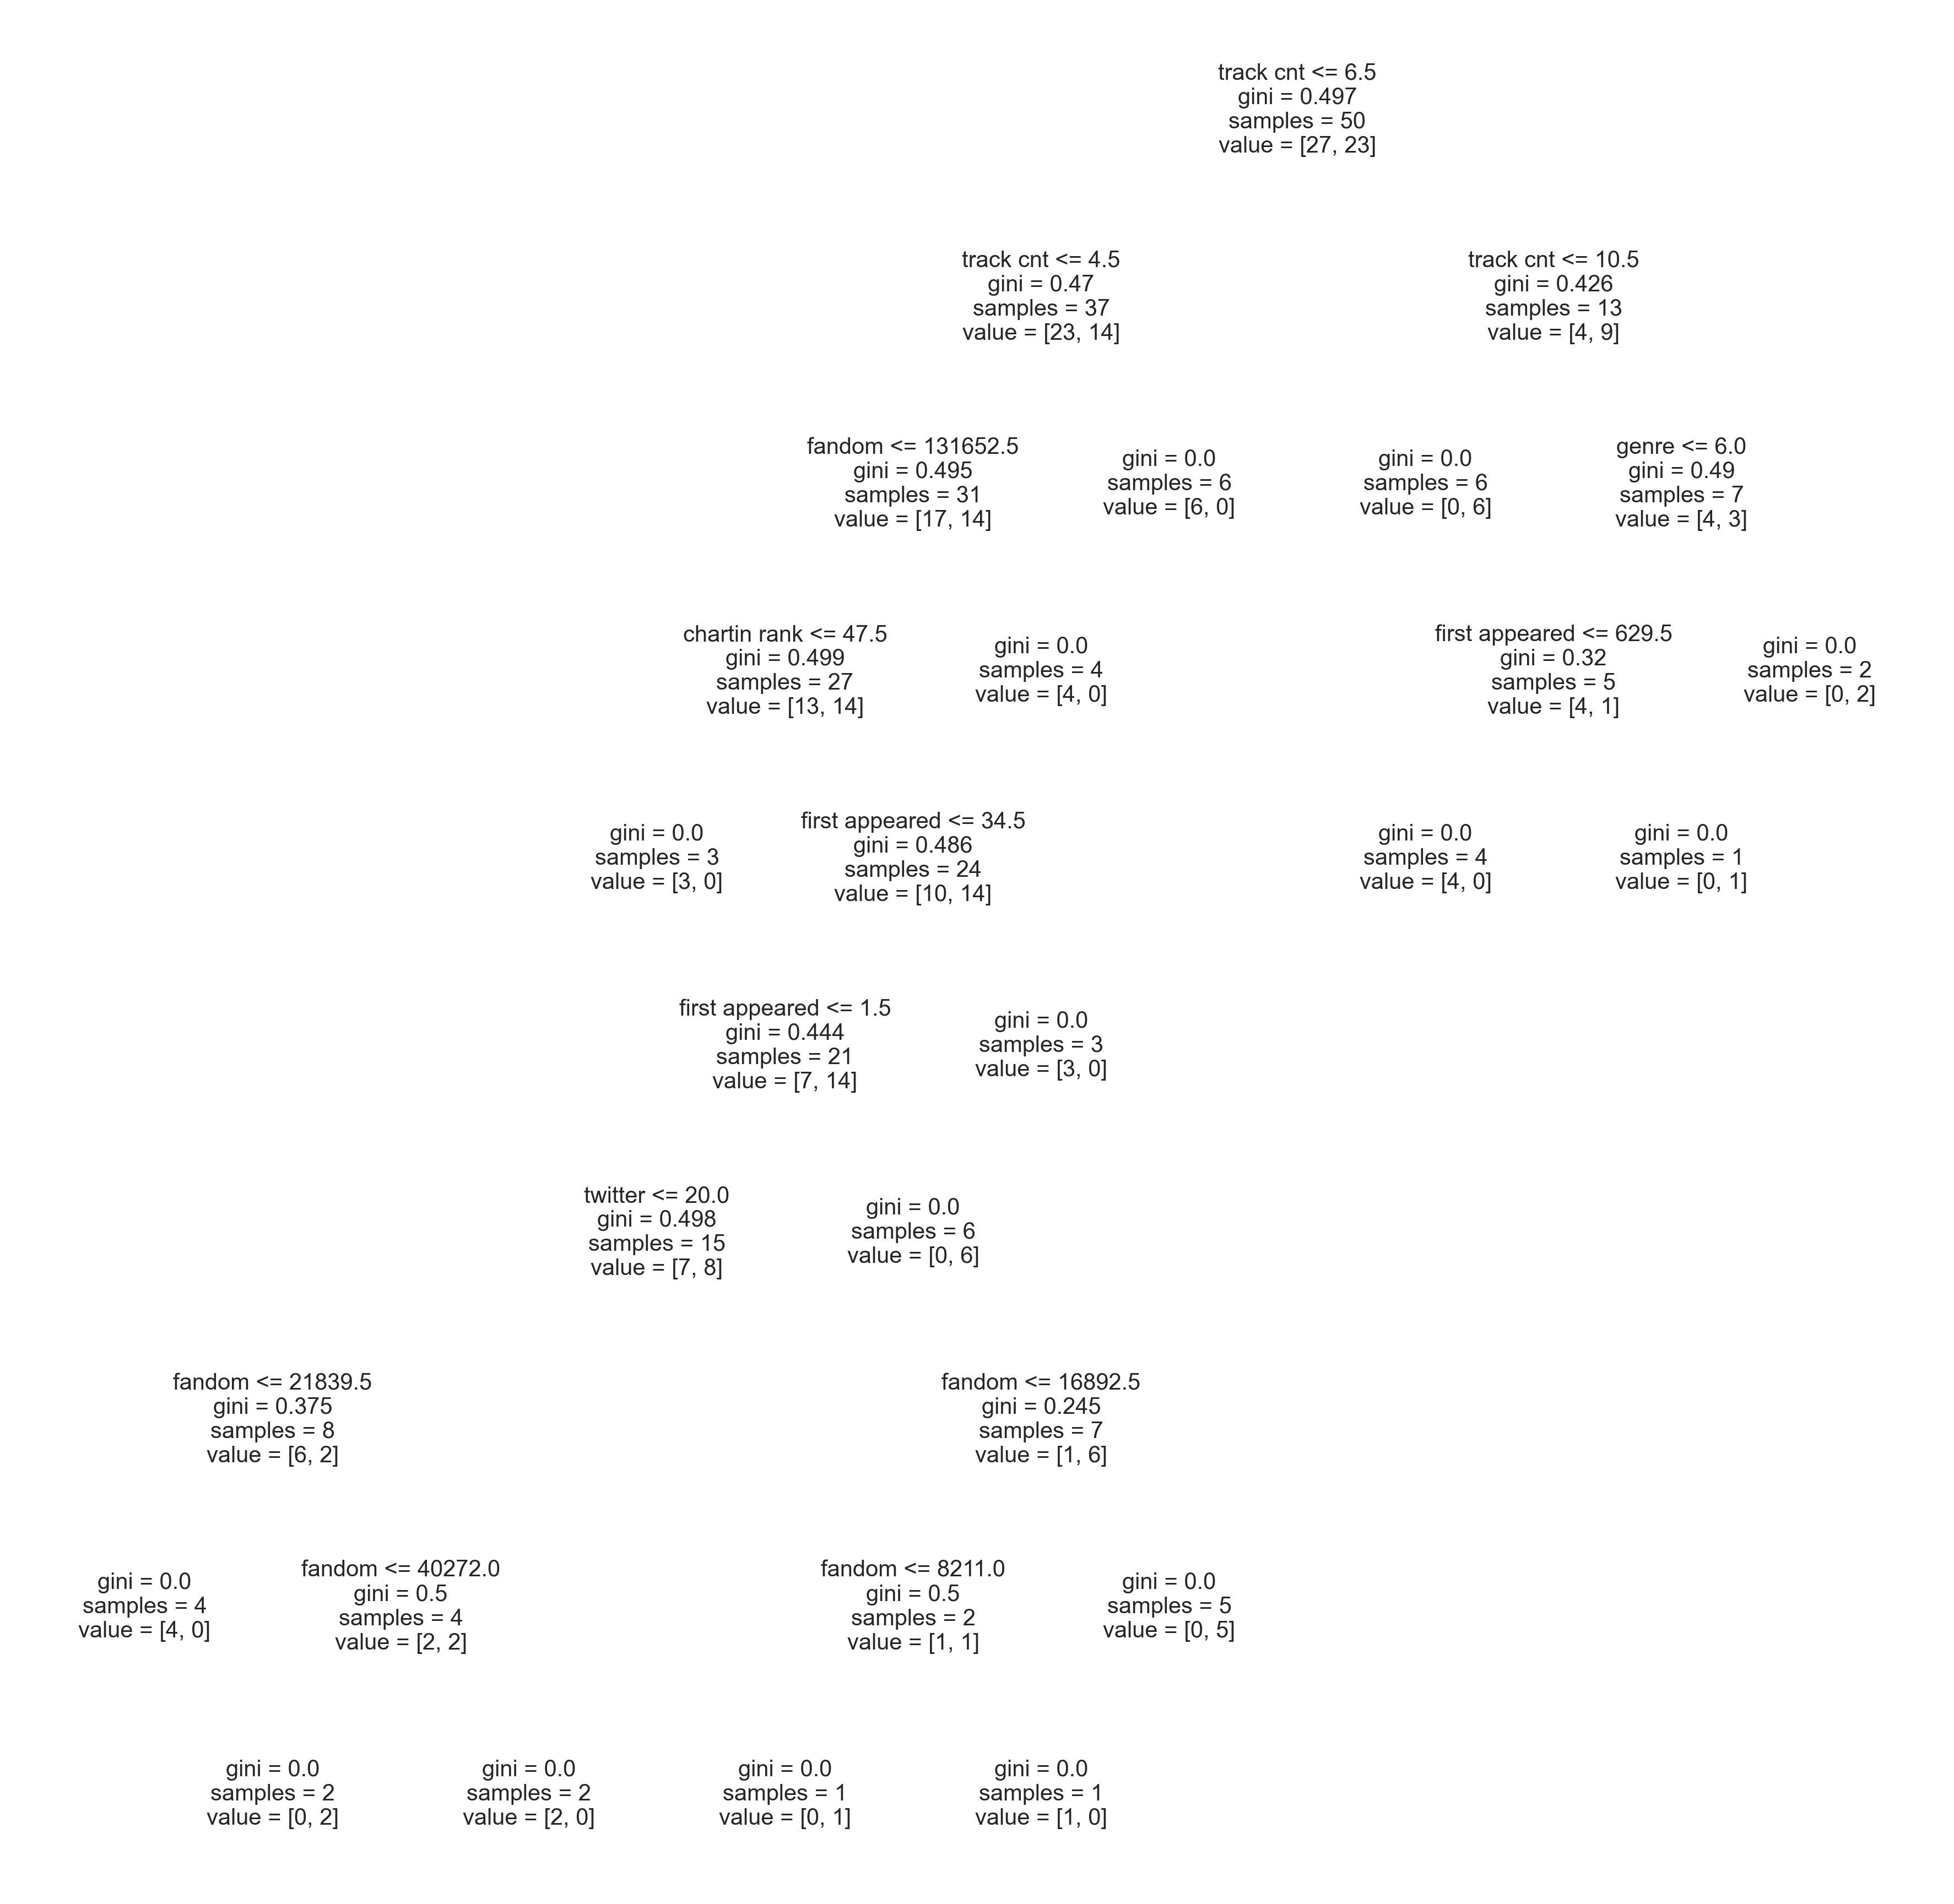

In [174]:
#Decision Tree 시각화
fig, ax = plt.subplots(figsize=(15, 15), dpi = 300)
tree.plot_tree(clf, fontsize = 10, feature_names = list(final_df.columns)[:-1], rounded = True)
plt.show()

<BarContainer object of 7 artists>

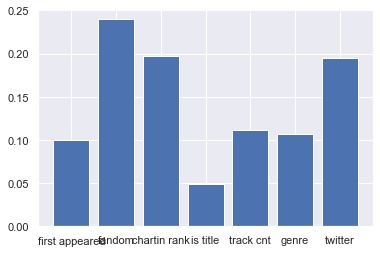

In [175]:
#Random Forest에서 각 요소의 중요도 시각화하기
X = []
Y = []
importance = model.feature_importances_

for i in range(7):
    X.append(final_df.columns[:9][i])
    Y.append(importance[i])
    
plt.bar(X, Y)